In [4]:
from os import path
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Định nghĩa đường dẫn
DATA_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\data"
RESULT_DIR = r"c:\Users\Admin\Python\ABSA_Prompting\results"
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULT_DIR, exist_ok=True)

In [5]:
# CONFIG - Hotel dataset

ViABSA_Hotel_dir = path.join(DATA_DIR, 'ViABSA_Hotel')
train_file = path.join(ViABSA_Hotel_dir, 'data_train.csv')
test_file = path.join(ViABSA_Hotel_dir, 'data_test.csv')

train_df = pd.read_csv(train_file)
test_df = pd.read_csv(test_file)

print(f"Train data shape: {train_df.shape}")
print(f"Test data shape: {test_df.shape}")
print(f"Columns (first 10): {list(train_df.columns)[:10]}")
print(f"Total columns: {len(train_df.columns)}")

# SETUP DATA - Hotel aspects
# Hotel dataset có format tương tự Restaurant: Review, aspect_columns với giá trị 0,1,2,3
aspects = [col for col in train_df.columns if col != 'Review']
print(f"\nNumber of aspects: {len(aspects)}")
print(f"Sample aspects: {aspects[:10]}")

# Sử dụng train/test datasets có sẵn
train_data = train_df.copy()
test_data = test_df.copy()

print(f"Train size: {len(train_data)}")
print(f"Test size: {len(test_data)}")

# Tạo binary labels cho aspect detection
for aspect in aspects:
    train_data[aspect + '_label'] = (train_data[aspect] != 0).astype(int)
    test_data[aspect + '_label'] = (test_data[aspect] != 0).astype(int)

aspect_labels = [aspect + '_label' for aspect in aspects]

X_train = train_data['Review']
y_train_aspect = train_data[aspect_labels]
X_test = test_data['Review']
y_test_aspect = test_data[aspect_labels]

print(f"\nX_train shape: {X_train.shape}")
print(f"y_train_aspect shape: {y_train_aspect.shape}")

# Thống kê về aspects
print("\nTop 10 most mentioned aspects:")
aspect_counts = {}
for aspect in aspects:
    count = (train_data[aspect] != 0).sum()
    aspect_counts[aspect] = count

sorted_aspects = sorted(aspect_counts.items(), key=lambda x: x[1], reverse=True)
for aspect, count in sorted_aspects[:10]:
    print(f"{aspect}: {count} mentions")

Train data shape: (3000, 35)
Test data shape: (600, 35)
Columns (first 10): ['Review', 'FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES']
Total columns: 35

Number of aspects: 34
Sample aspects: ['FACILITIES#CLEANLINESS', 'FACILITIES#COMFORT', 'FACILITIES#DESIGN&FEATURES', 'FACILITIES#GENERAL', 'FACILITIES#MISCELLANEOUS', 'FACILITIES#PRICES', 'FACILITIES#QUALITY', 'FOOD&DRINKS#MISCELLANEOUS', 'FOOD&DRINKS#PRICES', 'FOOD&DRINKS#QUALITY']
Train size: 3000
Test size: 600

X_train shape: (3000,)
y_train_aspect shape: (3000, 34)

Top 10 most mentioned aspects:
SERVICE#GENERAL: 1912 mentions
HOTEL#GENERAL: 1282 mentions
LOCATION#GENERAL: 1196 mentions
HOTEL#COMFORT: 1139 mentions
ROOMS#DESIGN&FEATURES: 916 mentions
HOTEL#DESIGN&FEATURES: 877 mentions
FOOD&DRINKS#QUALITY: 672 mentions
ROOMS#CLEANLINESS: 658 mentions
FOOD&DRI

In [6]:
# Kiểm tra và lọc các aspects có ít nhất 2 classes
print("Filtering aspects with at least 2 classes...")
valid_aspects = []
valid_aspect_labels = []

for i, aspect in enumerate(aspects):
    aspect_label = aspect + '_label'
    unique_classes = y_train_aspect[aspect_label].unique()
    if len(unique_classes) >= 2:
        valid_aspects.append(aspect)
        valid_aspect_labels.append(aspect_label)
    else:
        print(f"Skipping {aspect}: only {len(unique_classes)} class(es) - {unique_classes}")

print(f"\nValid aspects: {len(valid_aspects)}/{len(aspects)}")
print(f"Filtered out: {len(aspects) - len(valid_aspects)} aspects")

# Sử dụng chỉ valid aspects
aspects_filtered = valid_aspects
y_train_aspect_filtered = y_train_aspect[valid_aspect_labels]
y_test_aspect_filtered = y_test_aspect[valid_aspect_labels]

print(f"\nFiltered y_train_aspect shape: {y_train_aspect_filtered.shape}")
print(f"Filtered y_test_aspect shape: {y_test_aspect_filtered.shape}")

# Pipeline phát hiện khía cạnh (multi-label) - Optimized for many aspects
pipeline_aspect = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=3000, ngram_range=(1, 2))),
    ('clf', MultiOutputClassifier(LogisticRegression(solver='liblinear', max_iter=1000)))
])

# Huấn luyện mô hình với filtered data
print("\nTraining aspect detection model...")
pipeline_aspect.fit(X_train, y_train_aspect_filtered)

# Dự đoán khía cạnh trên test set
print("Predicting aspects...")
y_pred_aspect = pipeline_aspect.predict(X_test)

print("Aspect detection completed!")

# Tính F1 score cho aspect detection
f1_ad = f1_score(y_test_aspect_filtered, y_pred_aspect, average='micro') 
print(f"\nF1_ad (Aspect Detection): {f1_ad:.4f}")

# F1 cho từng aspect (chỉ hiển thị top 15 aspects)
print("\nF1 scores for top 15 aspects:")
f1_individual = []
for i, aspect in enumerate(aspects_filtered):
    f1 = f1_score(y_test_aspect_filtered.iloc[:, i], y_pred_aspect[:, i])
    f1_individual.append((aspect, f1))

# Sắp xếp theo F1 score
f1_individual.sort(key=lambda x: x[1], reverse=True)
for aspect, f1 in f1_individual[:15]:
    print(f"{aspect}: {f1:.4f}")

Filtering aspects with at least 2 classes...
Skipping ROOM_AMENITIES#PRICES: only 1 class(es) - [0]

Valid aspects: 33/34
Filtered out: 1 aspects

Filtered y_train_aspect shape: (3000, 33)
Filtered y_test_aspect shape: (600, 33)

Training aspect detection model...
Predicting aspects...
Aspect detection completed!

F1_ad (Aspect Detection): 0.6148

F1 scores for top 15 aspects:
SERVICE#GENERAL: 0.9642
LOCATION#GENERAL: 0.8905
FOOD&DRINKS#QUALITY: 0.7511
ROOMS#CLEANLINESS: 0.7283
ROOMS#DESIGN&FEATURES: 0.6768
HOTEL#GENERAL: 0.6639
FOOD&DRINKS#STYLE&OPTIONS: 0.6497
HOTEL#PRICES: 0.5370
HOTEL#DESIGN&FEATURES: 0.5354
HOTEL#COMFORT: 0.4058
ROOMS#COMFORT: 0.3158
HOTEL#CLEANLINESS: 0.2989
FACILITIES#DESIGN&FEATURES: 0.2368
ROOM_AMENITIES#DESIGN&FEATURES: 0.2195
ROOM_AMENITIES#GENERAL: 0.2128
Predicting aspects...
Aspect detection completed!

F1_ad (Aspect Detection): 0.6148

F1 scores for top 15 aspects:
SERVICE#GENERAL: 0.9642
LOCATION#GENERAL: 0.8905
FOOD&DRINKS#QUALITY: 0.7511
ROOMS#CLEANLI

In [7]:
# Map nhãn cảm xúc thành số cho Hotel dataset (giống Restaurant)
# Hotel format: 0=none, 1=positive, 2=neutral, 3=negative
sentiment_map = {0: -1, 1: 2, 2: 1, 3: 0}  # Map to: -1=none, 0=negative, 1=neutral, 2=positive

# Chuẩn bị y_train_sentiment và y_test_sentiment cho filtered aspects
y_train_sentiment = {}
y_test_sentiment = {}

for aspect in aspects_filtered:
    y_train_sentiment[aspect] = train_data[aspect].map(sentiment_map).fillna(-1).astype(int)
    y_test_sentiment[aspect] = test_data[aspect].map(sentiment_map).fillna(-1).astype(int)

print("Sentiment mapping completed!")

# Huấn luyện bộ phân loại cảm xúc cho từng khía cạnh (chỉ train cho những aspect có đủ dữ liệu)
pipeline_sentiment = {}
min_samples = 10  # Yêu cầu tối thiểu 10 samples để train
trained_aspects = 0

print("Training sentiment classification models...")

for aspect in aspects_filtered:
    # Chọn mẫu có khía cạnh trong tập train
    mask_train = y_train_aspect_filtered[aspect + '_label'] == 1
    X_train_aspect = X_train[mask_train]
    y_train_aspect_sent = y_train_sentiment[aspect][mask_train]
    
    # Kiểm tra xem có đủ dữ liệu và đa dạng về sentiment không
    unique_sentiments = y_train_aspect_sent.unique()
    valid_sentiments = [s for s in unique_sentiments if s != -1]
    
    if len(X_train_aspect) >= min_samples and len(valid_sentiments) > 1:
        pipe = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=2000, ngram_range=(1, 2))),
            ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear', max_iter=1000)))
        ])
        pipe.fit(X_train_aspect, y_train_aspect_sent)
        pipeline_sentiment[aspect] = pipe
        trained_aspects += 1
        if trained_aspects <= 10:  # Chỉ in 10 đầu tiên
            print(f"  - Trained sentiment classifier for {aspect} ({len(X_train_aspect)} samples)")
    else:
        pipeline_sentiment[aspect] = None

print(f"\nTrained sentiment classifiers for {trained_aspects}/{len(aspects_filtered)} aspects")

Sentiment mapping completed!
Training sentiment classification models...
  - Trained sentiment classifier for FACILITIES#CLEANLINESS (172 samples)
  - Trained sentiment classifier for FACILITIES#COMFORT (132 samples)
  - Trained sentiment classifier for FACILITIES#DESIGN&FEATURES (525 samples)
  - Trained sentiment classifier for FACILITIES#GENERAL (219 samples)
  - Trained sentiment classifier for FACILITIES#MISCELLANEOUS (33 samples)
  - Trained sentiment classifier for FACILITIES#PRICES (53 samples)
  - Trained sentiment classifier for FACILITIES#DESIGN&FEATURES (525 samples)
  - Trained sentiment classifier for FACILITIES#GENERAL (219 samples)
  - Trained sentiment classifier for FACILITIES#MISCELLANEOUS (33 samples)
  - Trained sentiment classifier for FACILITIES#PRICES (53 samples)
  - Trained sentiment classifier for FACILITIES#QUALITY (208 samples)
  - Trained sentiment classifier for FOOD&DRINKS#MISCELLANEOUS (13 samples)
  - Trained sentiment classifier for FOOD&DRINKS#PRICES

In [8]:
# Dự đoán cảm xúc cho từng khía cạnh trên test set
print("Predicting sentiments...")
num_samples = len(X_test)
y_pred_sentiment = np.full((num_samples, len(aspects_filtered)), -1)  # -1 nghĩa là không dự đoán

predicted_aspects = 0
for i, aspect in enumerate(aspects_filtered):
    pipe = pipeline_sentiment[aspect]
    if pipe is not None:
        mask_pred = y_pred_aspect[:, i] == 1
        if np.any(mask_pred):
            X_test_aspect = X_test[mask_pred]
            y_pred_sentiment[mask_pred, i] = pipe.predict(X_test_aspect)
            predicted_aspects += 1
            if predicted_aspects <= 10:  # Chỉ in 10 đầu tiên
                print(f"  - Predicted sentiments for {aspect} ({np.sum(mask_pred)} samples)")

print(f"\nPredicted sentiments for {predicted_aspects} aspects")

# Tính F1_sc cho từng khía cạnh và trung bình
f1_sc_list = []
aspect_f1_sc = []

print("\nSentiment Classification F1 scores (top 15):")

for i, aspect in enumerate(aspects_filtered):
    mask = (y_pred_aspect[:, i] == 1) & (y_test_sentiment[aspect] != -1)
    if np.sum(mask) > 0:
        f1 = f1_score(
            y_test_sentiment[aspect][mask],
            y_pred_sentiment[mask, i],
            average='weighted'
        )
        f1_sc_list.append(f1)
        aspect_f1_sc.append((aspect, f1))

# Sắp xếp và hiển thị top 15
aspect_f1_sc.sort(key=lambda x: x[1], reverse=True)
for aspect, f1 in aspect_f1_sc[:15]:
    print(f"F1_sc ({aspect}): {f1:.4f}")

f1_sc = np.mean(f1_sc_list) if f1_sc_list else 0
print(f"\nF1_sc (Sentiment Classification, average): {f1_sc:.4f}")
print(f"Number of aspects with valid predictions: {len(f1_sc_list)}")

Predicting sentiments...
  - Predicted sentiments for FACILITIES#DESIGN&FEATURES (11 samples)
  - Predicted sentiments for FACILITIES#QUALITY (1 samples)
  - Predicted sentiments for FOOD&DRINKS#QUALITY (100 samples)
  - Predicted sentiments for FOOD&DRINKS#STYLE&OPTIONS (73 samples)
  - Predicted sentiments for HOTEL#CLEANLINESS (20 samples)
  - Predicted sentiments for HOTEL#COMFORT (44 samples)
  - Predicted sentiments for HOTEL#DESIGN&FEATURES (42 samples)
  - Predicted sentiments for HOTEL#GENERAL (90 samples)
  - Predicted sentiments for HOTEL#PRICES (37 samples)
  - Predicted sentiments for LOCATION#GENERAL (190 samples)

Predicted sentiments for 20 aspects

Sentiment Classification F1 scores (top 15):
F1_sc (FACILITIES#QUALITY): 1.0000
F1_sc (HOTEL#CLEANLINESS): 1.0000
F1_sc (ROOMS#PRICES): 1.0000
F1_sc (ROOMS#QUALITY): 1.0000
F1_sc (ROOM_AMENITIES#COMFORT): 1.0000
F1_sc (ROOM_AMENITIES#GENERAL): 1.0000
F1_sc (HOTEL#GENERAL): 0.9668
F1_sc (HOTEL#PRICES): 0.9486
F1_sc (HOTEL#COM

FINAL RESULTS - HOTEL DATASET
F1_ad (Aspect Detection): 0.6148
F1_sc (Sentiment Classification): 0.8059
Total aspects (original): 34
Valid aspects (filtered): 33
Aspects with sentiment classifiers: 31
Aspects with valid predictions: 20
Train samples: 3000
Test samples: 600


c:\Users\Admin\Python\ABSA_Prompting\.venv\Lib\site-packages\sklearn\metrics\_classification.py:534: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


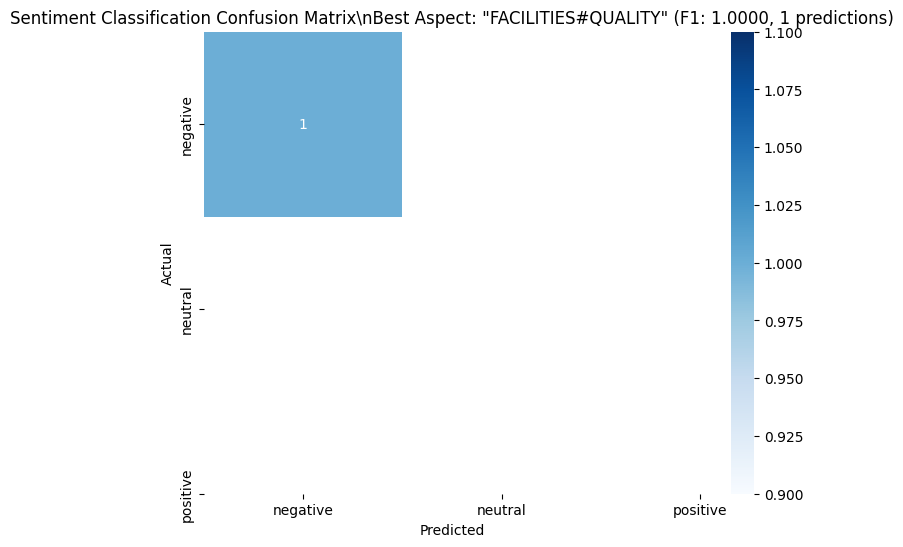

In [9]:
# Kết quả cuối cùng cho Hotel dataset
print("="*50)
print("FINAL RESULTS - HOTEL DATASET")
print("="*50)
print(f"F1_ad (Aspect Detection): {f1_ad:.4f}")
print(f"F1_sc (Sentiment Classification): {f1_sc:.4f}")
print(f"Total aspects (original): {len(aspects)}")
print(f"Valid aspects (filtered): {len(aspects_filtered)}")
print(f"Aspects with sentiment classifiers: {trained_aspects}")
print(f"Aspects with valid predictions: {len(f1_sc_list)}")
print(f"Train samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")

# Confusion matrix cho sentiment classification (chọn aspect có F1 score cao nhất)
if aspect_f1_sc:  # Nếu có ít nhất 1 aspect được đánh giá
    best_aspect, best_f1_sc = aspect_f1_sc[0]
    idx = aspects_filtered.index(best_aspect)
    mask = (y_pred_aspect[:, idx] == 1) & (y_test_sentiment[best_aspect] != -1)
    
    if np.sum(mask) > 0:
        cm = confusion_matrix(y_test_sentiment[best_aspect][mask], y_pred_sentiment[mask, idx])
        
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['negative', 'neutral', 'positive'], 
                   yticklabels=['negative', 'neutral', 'positive'])
        plt.title(f'Sentiment Classification Confusion Matrix\\nBest Aspect: "{best_aspect}" (F1: {best_f1_sc:.4f}, {np.sum(mask)} predictions)')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
    else:
        print(f"No valid predictions for aspect '{best_aspect}'")
else:
    print("No aspects with valid sentiment predictions found")


Performance analysis by aspect groups:
High F1 (≥0.7) aspects: 4
Medium F1 (0.3-0.7) aspects: 7
Low F1 (<0.3) aspects: 22

Top performing aspects: ['SERVICE#GENERAL', 'LOCATION#GENERAL', 'FOOD&DRINKS#QUALITY', 'ROOMS#CLEANLINESS']

Low performing aspects: ['HOTEL#CLEANLINESS', 'FACILITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#DESIGN&FEATURES', 'ROOM_AMENITIES#GENERAL', 'ROOMS#QUALITY', 'ROOMS#PRICES', 'FACILITIES#QUALITY', 'ROOM_AMENITIES#QUALITY', 'ROOM_AMENITIES#COMFORT', 'FACILITIES#CLEANLINESS']

Confusion matrix for best performing aspect 'SERVICE#GENERAL' (F1: 0.9642):


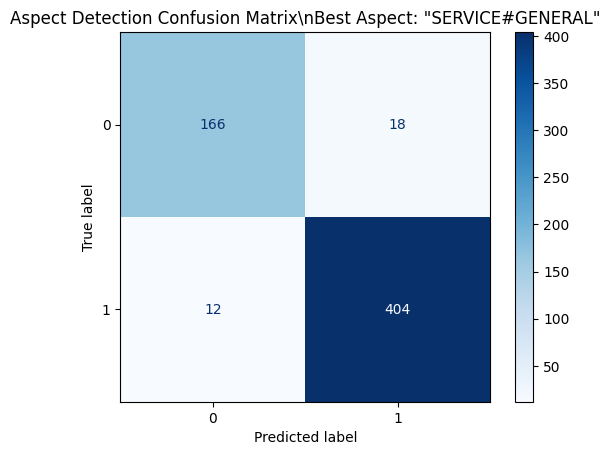


Filtered aspects summary:
- Removed aspects (single class): 1
- Removed aspects: ['ROOM_AMENITIES#PRICES']


In [10]:
# Tóm tắt hiệu suất theo nhóm aspects
print("\nPerformance analysis by aspect groups:")

# Nhóm theo F1 score
high_f1 = [a for a, f1 in f1_individual if f1 >= 0.7]
medium_f1 = [a for a, f1 in f1_individual if 0.3 <= f1 < 0.7]
low_f1 = [a for a, f1 in f1_individual if f1 < 0.3]

print(f"High F1 (≥0.7) aspects: {len(high_f1)}")
print(f"Medium F1 (0.3-0.7) aspects: {len(medium_f1)}")
print(f"Low F1 (<0.3) aspects: {len(low_f1)}")

if high_f1:
    print(f"\nTop performing aspects: {high_f1[:10]}")
if low_f1:
    print(f"\nLow performing aspects: {low_f1[:10]}")

# Confusion matrix cho aspect có F1 score cao nhất trong aspect detection
if f1_individual:
    best_aspect, best_f1 = f1_individual[0]
    idx = aspects_filtered.index(best_aspect)
    print(f"\nConfusion matrix for best performing aspect '{best_aspect}' (F1: {best_f1:.4f}):")

    cm = confusion_matrix(y_test_aspect_filtered[best_aspect + '_label'], y_pred_aspect[:, idx])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap='Blues')
    plt.title(f'Aspect Detection Confusion Matrix\\nBest Aspect: "{best_aspect}"')
    plt.show()

# Thống kê về filtered aspects
print(f"\nFiltered aspects summary:")
print(f"- Removed aspects (single class): {len(aspects) - len(aspects_filtered)}")
if len(aspects) - len(aspects_filtered) > 0:
    removed_aspects = [a for a in aspects if a not in aspects_filtered]
    print(f"- Removed aspects: {removed_aspects[:10]}{'...' if len(removed_aspects) > 10 else ''}")